In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from numpy.linalg import norm
from tqdm import tqdm
import cv2
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

In [11]:
# Charger le modèle ResNet50 pré-entraîné
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model.trainable = False

model = tf.keras.Sequential([
    model,
    GlobalMaxPooling2D()  # Réduire la dimension des vecteurs d'embedding
])

In [12]:
def extract_features(img_path,model):
    img = image.load_img(img_path,target_size=(224,224))
    img_array=image.img_to_array(img)
    expanded_img_array=np.expand_dims(img_array,axis=0)
    preprocessed_img=preprocess_input(expanded_img_array)
    result=model.predict(preprocessed_img, verbose=0).flatten()
    normalized_result = result / norm(result) # Chaque vecteur est de longueur 1

    return normalized_result

def extract_all_features(image_list, model):
    features = []
    for file in tqdm(image_list, desc='Extraction des features'):
        feature = extract_features(file, model)
        features.append(feature)
    return features

# Fonction pour obtenir les images les plus similaires
def get_similar_images(image_feature, NN, filenames, top_k=5):
    distances, indices = NN.kneighbors([image_feature])
    similar_images = [filenames[i] for i in indices[0][1:top_k+1]]
    return similar_images

In [17]:
# Extraire le contenu des images depuis le fichier zip

# Chemin du fichier zip
zip_file_path = 'data_image.zip'

# Dossier de destination
destination_folder = 'sample_image'

# Créer le dossier de destination s'il n'existe pas
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Extraire le contenu des images directement dans le dossier destination
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Parcourir les fichiers dans le zip
   for file in tqdm(zip_ref.namelist(), desc="Extraction des fichiers"):
        # Extraire chaque fichier dans le dossier de destination
        zip_ref.extract(file, destination_folder)

# Extraire les noms des fichiers
filenames = []
for root, dirs, files in os.walk(destination_folder):
    for file in files:
        filenames.append(os.path.join(root, file))

print(filenames[:5])

Extraction des fichiers: 100%|██████████| 1000/1000 [00:01<00:00, 825.22it/s]

['sample_image\\data_image\\10054.jpg', 'sample_image\\data_image\\10062.jpg', 'sample_image\\data_image\\10065.jpg', 'sample_image\\data_image\\10096.jpg', 'sample_image\\data_image\\10250.jpg']


In [14]:
# Diviser les données en ensembles d'entraînement et de test
train_filenames, test_filenames = train_test_split(filenames, test_size=0.2, random_state=42)

# Extraire les caractéristiques des ensembles d'entraînement et de test
train_features = extract_all_features(train_filenames, model)
test_features = extract_all_features(test_filenames, model)

# Entraîner le modèle NearestNeighbors sur l'ensemble d'entraînement
NN = NearestNeighbors(n_neighbors=7, algorithm='brute', metric='euclidean')
NN.fit(train_features)

100%|██████████| 200/200 [00:33<00:00,  5.99it/s]


NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=7)

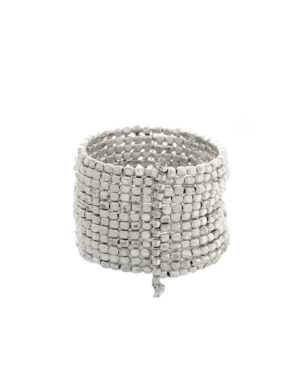

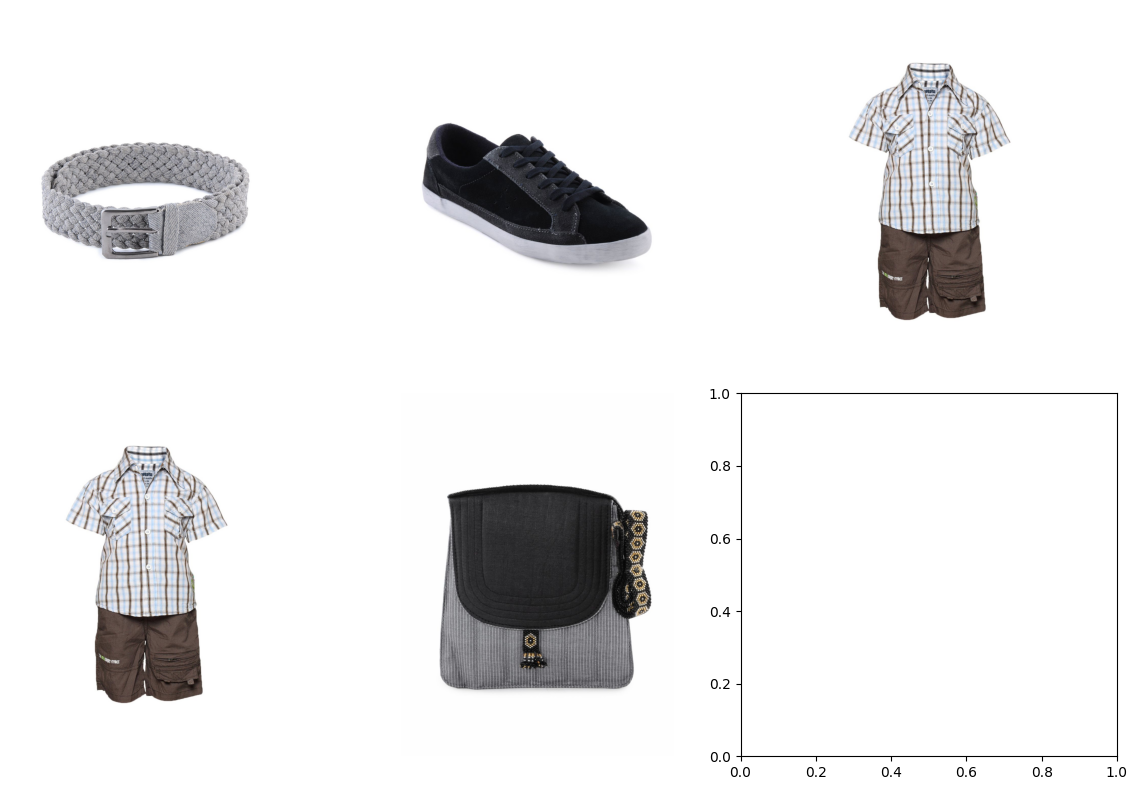

In [15]:
# Exemple de recommandation pour une image de test
test_img = test_filenames[100]
processed_img = extract_features(test_img, model)
recommended_images = get_similar_images(processed_img, NN, train_filenames)

# Afficher l'image test et les images recommandées
raw_img = cv2.imread(test_img)
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
plt.imshow(raw_img)
plt.axis('off')
plt.show()

num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
axes = axes.ravel()
for i, file in enumerate(recommended_images):
    temp_img = cv2.imread(file)
    image_rgb = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(image_rgb)
    axes[i].axis('off')
plt.tight_layout()
plt.show()
